In [1]:
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import requests
from pathlib import Path

In [2]:
N_SAMPLES = 1000

In [3]:
print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

2.1.2+cu118
cuda


In [4]:
X, y = make_circles(N_SAMPLES, noise=0.03, random_state=42)

In [5]:
len(X),len(y)

(1000, 1000)

In [6]:
print(f"First 5 samples of X: \n {X[:5]}")
print(f"First 5 samples of Y: \n {y[:5]}") 

First 5 samples of X: 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of Y: 
 [1 1 1 1 0]


In [7]:
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "Label": y})
circles.head(10)

,X1,X2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


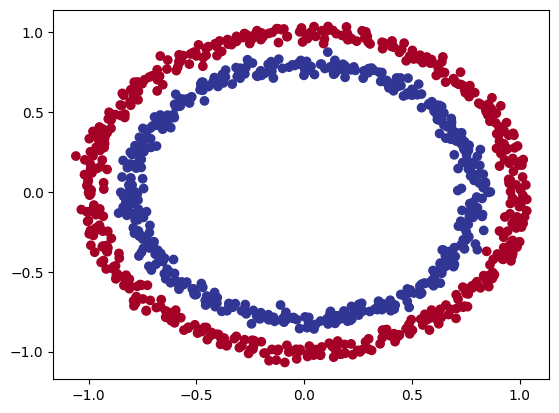

In [8]:
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

## Check input and output shapes

In [9]:
X.shape, y.shape

((1000, 2), (1000,))

In [10]:
X_sample = X[0]
y_sample = y[0]

print(f"Values of X: {X_sample} and Y: {y_sample}")
print(f"Shapes of X: {X_sample.shape} and Y: {y_sample.shape}")

Values of X: [0.75424625 0.23148074] and Y: 1
Shapes of X: (2,) and Y: ()


## Convert into Tensors

In [11]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Build a model

In [13]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=1)
    def forward(self, x):
        l1 = self.layer_1(x)
        l2 = self.layer_2(l1)
        return l2

In [14]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [15]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [16]:
model_0_seq = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=1)
).to(device)

model_0_seq

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
)

In [17]:
model_0_seq.state_dict()

OrderedDict([('0.weight',
              tensor([[ 2.3192e-04, -6.6723e-01],
                      [ 6.7358e-01, -6.8233e-02],
                      [-6.9597e-01, -5.7915e-01],
                      [-5.7931e-01,  2.7436e-01],
                      [-8.2184e-02, -2.0317e-01],
                      [-5.8349e-01,  5.4734e-01],
                      [-4.4361e-01, -9.7322e-02],
                      [ 2.5524e-01,  4.7937e-01]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.2949, -0.5730, -0.1865,  0.3431,  0.1319,  0.0824, -0.0323, -0.5469],
                     device='cuda:0')),
             ('2.weight',
              tensor([[-0.3291,  0.2302, -0.1519,  0.1780, -0.0956, -0.0031, -0.0864,  0.1316],
                      [-0.0172, -0.1042,  0.1307, -0.1821, -0.1284, -0.3257, -0.2332, -0.1362],
                      [ 0.3223,  0.0701, -0.2597, -0.2914,  0.2555, -0.2110,  0.3340,  0.0916],
                      [ 0.0089,  0.3135,  0.0013, -0.0264, -0.0959,  0.1124, -0.3

In [18]:
with torch.inference_mode():
    untrained_preds = model_0_seq(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"First 10 predictions: \n {untrained_preds[:10]}") 

Length of predictions: 200, Shape: torch.Size([200, 1])
First 10 predictions: 
 tensor([[0.0505],
        [0.0545],
        [0.1557],
        [0.0417],
        [0.2179],
        [0.2064],
        [0.1414],
        [0.1462],
        [0.1505],
        [0.0565]], device='cuda:0')


In [19]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [20]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0_seq.parameters(),lr=0.1)

## Train model

In [21]:
model_0_seq.eval()
with torch.inference_mode():
    y_logits = model_0_seq(X_test.to(device))

In [22]:
y_pred_probs = torch.sigmoid(y_logits)

In [23]:
y_preds = torch.round(y_pred_probs)

In [24]:
epochs = 1500
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0_seq.train()

    y_logits = model_0_seq(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()
    
    optimizer.step()

    model_0_seq.eval()
    with torch.inference_mode():
        test_logits = model_0_seq(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred=test_pred)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69690, Acc: 50.00% | Test loss: 0.69397, Test acc: 50.00%
Epoch: 10 | Loss: 0.69526, Acc: 54.62% | Test loss: 0.69271, Test acc: 59.50%
Epoch: 20 | Loss: 0.69437, Acc: 51.00% | Test loss: 0.69207, Test acc: 56.00%
Epoch: 30 | Loss: 0.69385, Acc: 50.62% | Test loss: 0.69174, Test acc: 56.00%
Epoch: 40 | Loss: 0.69354, Acc: 50.25% | Test loss: 0.69158, Test acc: 52.50%
Epoch: 50 | Loss: 0.69336, Acc: 50.38% | Test loss: 0.69151, Test acc: 47.50%
Epoch: 60 | Loss: 0.69323, Acc: 51.00% | Test loss: 0.69148, Test acc: 49.50%
Epoch: 70 | Loss: 0.69314, Acc: 50.12% | Test loss: 0.69146, Test acc: 49.50%
Epoch: 80 | Loss: 0.69306, Acc: 50.00% | Test loss: 0.69146, Test acc: 50.00%
Epoch: 90 | Loss: 0.69299, Acc: 50.50% | Test loss: 0.69146, Test acc: 49.00%
Epoch: 100 | Loss: 0.69293, Acc: 50.38% | Test loss: 0.69146, Test acc: 48.50%
Epoch: 110 | Loss: 0.69287, Acc: 50.00% | Test loss: 0.69146, Test acc: 48.50%
Epoch: 120 | Loss: 0.69281, Acc: 50.00% | Test loss: 0.69145, T

### Make predictions and evaluate models

In [25]:
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping downlod.")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping downlod.


In [26]:
from helper_functions import plot_predictions, plot_decision_boundary

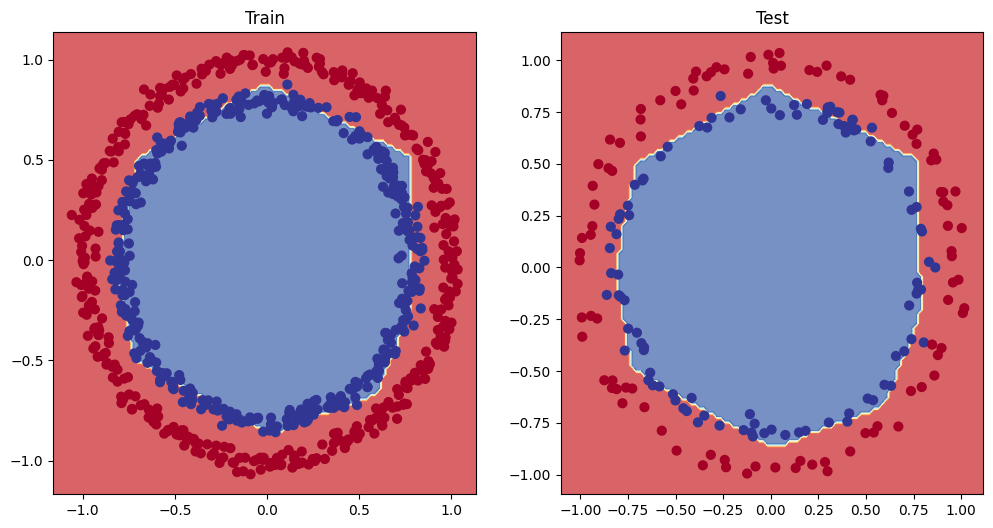

In [27]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0_seq, X_train, y_train)
plt.subplot(1, 2 ,2)
plt.title("Test")
plot_decision_boundary(model_0_seq, X_test, y_test)

In [28]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=16)
        self.layer_3 = nn.Linear(in_features=16, out_features=1)

    def forward(self, x):
        logits = self.layer_3(self.layer_2(self.layer_1(x)))
        return logits

In [29]:
model_1 = CircleModelV1()
model_1.to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
)

In [30]:
loss_fn_1 = nn.BCEWithLogitsLoss()
optimizer_1 = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [31]:
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test  = X_test.to(device), y_test.to(device)



In [32]:
for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn_1(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer_1.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn_1(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70396, Acc: 50.00% | Test loss: 0.70572, Test acc: 50.00%
Epoch: 100 | Loss: 0.70396, Acc: 50.00% | Test loss: 0.70572, Test acc: 50.00%
Epoch: 200 | Loss: 0.70396, Acc: 50.00% | Test loss: 0.70572, Test acc: 50.00%
Epoch: 300 | Loss: 0.70396, Acc: 50.00% | Test loss: 0.70572, Test acc: 50.00%
Epoch: 400 | Loss: 0.70396, Acc: 50.00% | Test loss: 0.70572, Test acc: 50.00%
Epoch: 500 | Loss: 0.70396, Acc: 50.00% | Test loss: 0.70572, Test acc: 50.00%
Epoch: 600 | Loss: 0.70396, Acc: 50.00% | Test loss: 0.70572, Test acc: 50.00%
Epoch: 700 | Loss: 0.70396, Acc: 50.00% | Test loss: 0.70572, Test acc: 50.00%
Epoch: 800 | Loss: 0.70396, Acc: 50.00% | Test loss: 0.70572, Test acc: 50.00%
Epoch: 900 | Loss: 0.70396, Acc: 50.00% | Test loss: 0.70572, Test acc: 50.00%


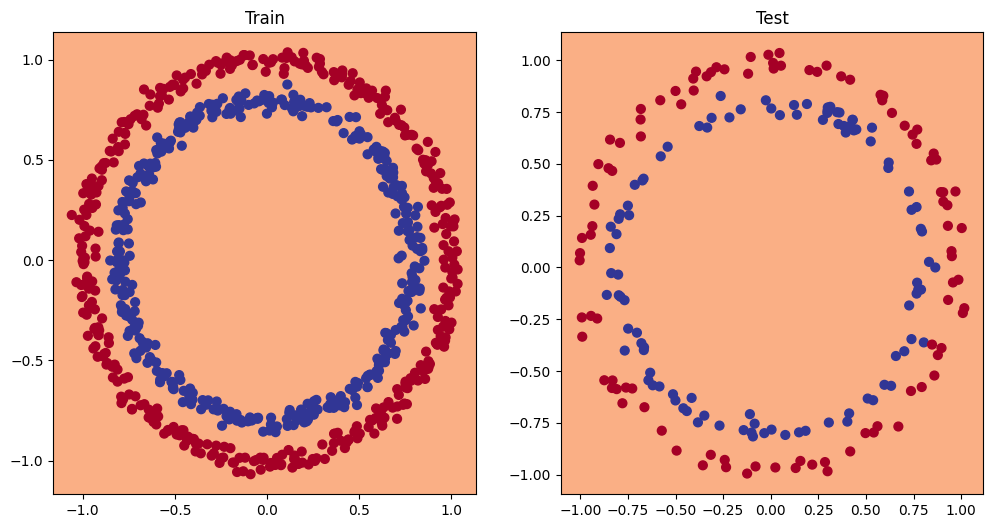

In [33]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2 ,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [36]:
class CirlceModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [37]:
model_3 = CirlceModelV2().to(device)
model_3

CirlceModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [39]:
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test  = X_test.to(device), y_test.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [42]:
for epoch in range(epochs):
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss: {loss:.5f} Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} Test Acc: {test_acc:.2f}%")

Epoch 0: Train Loss: 0.69946 Train Acc: 50.00% | Test Loss: 0.69713 Test Acc: 50.00%
Epoch 100: Train Loss: 0.68508 Train Acc: 69.75% | Test Loss: 0.68644 Test Acc: 67.00%
Epoch 200: Train Loss: 0.67846 Train Acc: 72.75% | Test Loss: 0.68171 Test Acc: 68.50%
Epoch 300: Train Loss: 0.66912 Train Acc: 76.50% | Test Loss: 0.67448 Test Acc: 75.00%
Epoch 400: Train Loss: 0.65322 Train Acc: 86.00% | Test Loss: 0.66126 Test Acc: 78.50%
Epoch 500: Train Loss: 0.62518 Train Acc: 91.25% | Test Loss: 0.63744 Test Acc: 84.50%
Epoch 600: Train Loss: 0.57018 Train Acc: 97.12% | Test Loss: 0.58869 Test Acc: 95.00%
Epoch 700: Train Loss: 0.47077 Train Acc: 99.88% | Test Loss: 0.49609 Test Acc: 100.00%
Epoch 800: Train Loss: 0.32685 Train Acc: 99.88% | Test Loss: 0.36241 Test Acc: 100.00%
Epoch 900: Train Loss: 0.19867 Train Acc: 99.88% | Test Loss: 0.23694 Test Acc: 100.00%


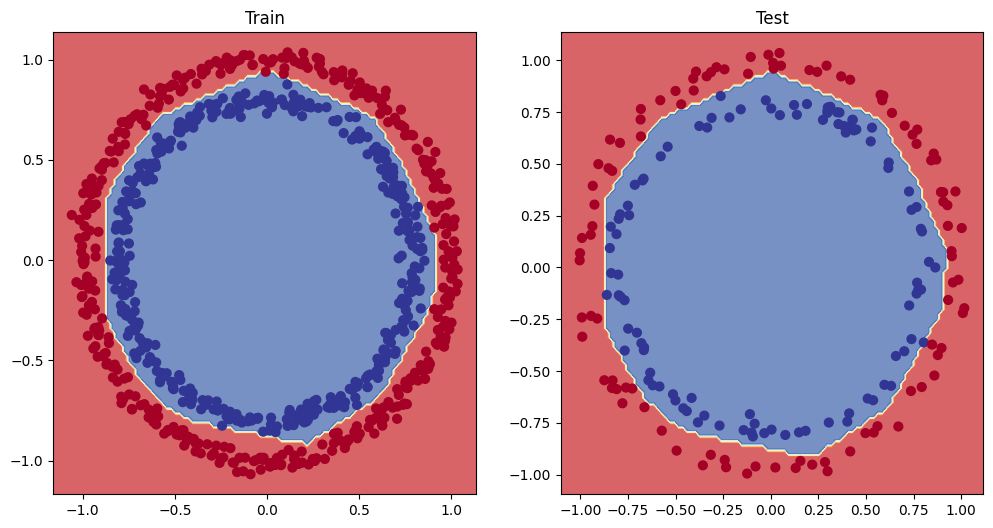

In [43]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2 ,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)